In [20]:
# The number of entries to read in. Use it to have fast turn-around
max_events = None
# Number on CV folds
n_cv = 5

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

import gc

import mlflow
import mlflow.sklearn

import keggler as kg

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

PATH = '/home/mlisovyi/.kaggle/competitions/santander-customer-transaction-prediction/'

print(os.listdir(PATH))

['train.csv', 'sample_submission.csv', 'test.csv']


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
df_trn = pd.read_csv(PATH+'train.csv')
# df_tst = pd.read_csv(PATH+'test.csv')

In [8]:
df_trn = kg.reduce_mem_usage(df_trn, force_obj_in_category=False)
# df_tst = kg.reduce_mem_usage(df_tst, force_obj_in_category=False)

Memory usage of dataframe is 319.76 MB
Memory usage after optimization is: 89.54 MB
Decreased by 72.0%


In [9]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# FE

In [10]:
def apply_fe(df):
    return df

In [11]:
df_trn = apply_fe(df_trn)

# Training

In [12]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


def learning_rate_decay_power(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    base_learning_rate = 0.1
    min_lr = 5.0e-2
    lr = base_learning_rate  * np.power(.998, current_iter)
    return lr if lr > min_lr else min_lr


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = KFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []
    feature_importances = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        scores.append(metric(y_true_tmp, y_pred_tmp, **metric_args))
        #
        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = X.columns
        if hasattr(clf, 'feature_importances_'):
            fi_tmp["importance"] = clf.feature_importances_
        fi_tmp["fold"] = n_fold + 1
        feature_importances.append(fi_tmp)
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof, pd.concat(feature_importances, axis=0)

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(['{:.4f}'.format(x) for x in perf_eval['score_i']]))

In [33]:
mdl_inputs = {
    'lgbm_base': (
        lgb.LGBMClassifier(
            max_depth=-1,
            min_child_samples=40,
            random_state=314,
            silent=True,
            metric='None',
            n_jobs=4,
            n_estimators=1000,
            importance_type='gain'),
        {
            'colsample_bytree': 0.75,
            'subsample': 0.75,
            'min_child_weight': 10.0,
            'num_leaves': 80,
            #'class_weight': 'balanced'
        },
        {
            "early_stopping_rounds": 50,
            "eval_metric": 'auc',
        },
        df_trn['target'],
        None),
}

features_not2use = ['ID_code', 'target']

In [34]:
# for v in ['var_89', 'var_139', 'var_12', 'var_81']:
#     kg.plot_var_for2classes(df_trn, v, bins=50,
#                             target_name='target')
#     plt.title(v)

In [43]:
feats = [c for c in df_trn.columns if c not in features_not2use]

n_trn = 5000
seed_cv = 31416

mdls = {}
results = {}
y_oofs = {}
fis = {}  # feature importances
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    with mlflow.start_run():
        print('--------------- {} -----------'.format(name))
        mdl_, perf_eval_, y_oof_, fi_ = train_model_in_CV(
            mdl,
            df_trn[feats].iloc[:n_trn, :],
            y_.iloc[:n_trn],
            roc_auc_score,
            metric_args={},
            model_name=name,
            opt_parameters_=mdl_pars,
            fit_params_=fit_pars,
            n=n_cv,
            seed=seed_cv,
            verbose=100,
            groups=g_)
        results[name] = perf_eval_
        mdls[name] = mdl_
        y_oofs[name] = y_oof_
        fis[name] = fi_
        print_perf_clf(name, perf_eval_)
        
        # Logging
        mlflow.log_param('model_name', name)
        for k, v in mdl_pars.items():
            mlflow.log_param(k, v)
        if n_trn is not None:
            mlflow.log_param('n_trn', n_trn)
        mlflow.log_param('seed_cv', seed_cv)
        # metrics
        mlflow.log_metric("AUC", perf_eval_['score_i_ave'])
        mlflow.log_metric("AUC_STD", perf_eval_['score_i_std'])
        for i in range(n_cv):
            mlflow.log_metric("AUC_Fold{}".format(i), perf_eval_['score_i'][i])
        # artifacts    
        y_oof_.to_csv('oof.csv')
        

--------------- lgbm_base -----------
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's auc: 1	valid_1's auc: 0.691745
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	training's auc: 1	valid_1's auc: 0.708595
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[19]	training's auc: 1	valid_1's auc: 0.708718
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's auc: 1	valid_1's auc: 0.7069
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	training's auc: 1	valid_1's auc: 0.635266
Performance of the model:
Mean(Val) score inner lgbm_base Classifier: 0.6902+-0.0282
Min/max scores on folds: 0.6353 / 0.7087
OOF score inner lgbm_base Classifier: 0.6903
Scores in individual folds: ['0.6917', '0.7086', '0.7087', '0.7069', '0.6

# Importances
## Gains

The list of features with 0 importance: 
[]


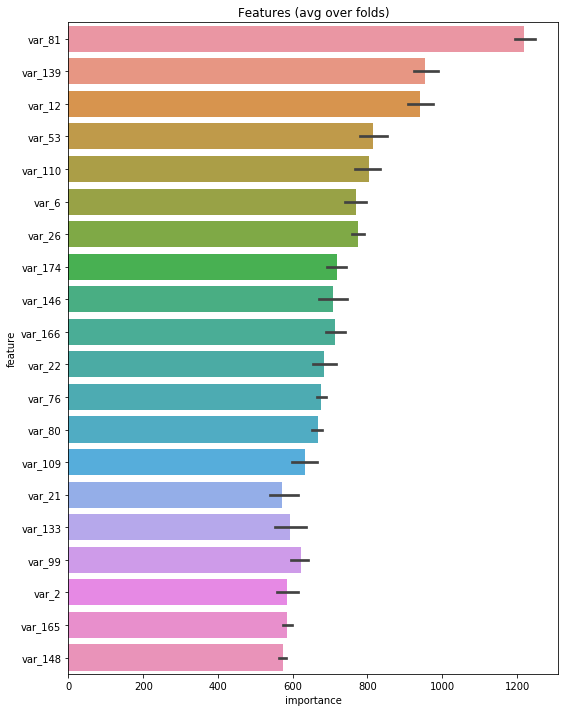

In [19]:
kg.display_importances(fis['lgbm_base'], n_feat=20)

## SHAP

In [16]:
import shap
shap.initjs()

In [29]:
n_shap=1000
explainer = shap.TreeExplainer(mdls['lgbm_base'][0][1])
shap_values = explainer.shap_values(df_trn[feats].iloc[:n_shap,:])

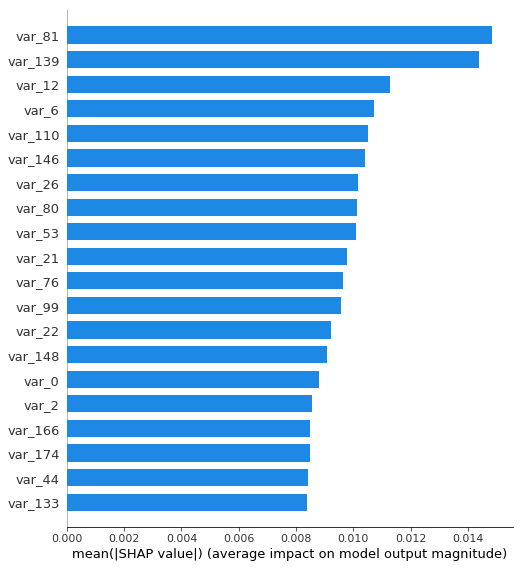

In [30]:
shap.summary_plot(shap_values, df_trn[feats].iloc[:n_shap,:], plot_type="bar")